In [1]:
import pandas as pd
from collections import Counter
import numpy as np
from matplotlib.table import table
from sklearn.neighbors import KernelDensity
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as grid_spec
import jinja2
import re
import tabulate
import ridgeplot as rg
import nbformat
from sympy import true, false

import seaborn as sns
import plotly.io as pio
pio.renderers.default = "notebook"
from IPython.display import IFrame
from reportlab.lib.pagesizes import letter
from reportlab.platypus import SimpleDocTemplate, Table, TableStyle, Paragraph, Spacer
from reportlab.lib import colors
from reportlab.lib.styles import getSampleStyleSheet
#Okay, we have our standardized street names. Now we start seeing how many crashes each has.
df = pd.read_csv("2012-24_Crash_Events_std_street_names_dataset.csv")
df = df.dropna(subset=["CaseYear", "CrashDate", "CrashTime"]).copy()

# Ensure CrashDate is datetime
df["CrashDate"] = pd.to_datetime(df["CrashDate"], errors="coerce")

# Prepare CrashHour from CrashTime
df["CrashHour"] = (df["CrashTime"] // 100).astype(int)


/tmp/ipykernel_32467/927982530.py:25: DtypeWarning:

Columns (0: CaseNumber) have mixed types. Specify dtype option on import or set low_memory=False.



In [2]:
df['Serious_and_Fatal_Injuries'] = df['NumberOfFatalities'] + df['NumberOfSeriousInjuries']

pared_df = []

df['OnStreet_standardized'].value_counts()

dropped_df = df[df.OnStreet_standardized != "UNKNOWN"]




In [3]:
#heatmap - fatal/serious injuries per streets and years
freqtb_y = pd.crosstab(dropped_df["Serious_and_Fatal_Injuries"], dropped_df["OnStreet_standardized"])



In [4]:
#top streets by number of serious injuries or deaths
streets = dropped_df["OnStreet_standardized"].unique()
years = dropped_df["CaseYear"].unique()
totalseriousinj = []


for street in streets:
    totalseriousinj.append([street, dropped_df[(dropped_df['OnStreet_standardized']==street)].Serious_and_Fatal_Injuries.sum()])
totalseriousinj


[['STATE ROUTE 104', np.int64(134)],
 ['STATE ROUTE 15A', np.int64(0)],
 ['FIRST STREET', np.int64(4)],
 ['STATE ROUTE 251', np.int64(1)],
 ['SECOND AVENUE', np.int64(0)],
 ['SECOND STREET', np.int64(0)],
 ['STATE ROUTE 31F', np.int64(2)],
 ['STATE ROUTE 33', np.int64(20)],
 ['390', np.int64(0)],
 ['THIRD STREET', np.int64(0)],
 ['STATE ROUTE 441', np.int64(20)],
 ['INTERSTATE 490', np.int64(229)],
 ['FOURTH AVENUE', np.int64(0)],
 ['FOURTH SECTION ROAD', np.int64(20)],
 ['FOURTH STREET', np.int64(1)],
 ['INTERSTATE 590', np.int64(37)],
 ['FIFTH STREET', np.int64(1)],
 ['STATE ROUTE 65', np.int64(2)],
 ['SIXTH STREET', np.int64(0)],
 ['SEVENTH STREET', np.int64(1)],
 ['EIGHTH STREET', np.int64(0)],
 ['9 MILE POINT ROAD', np.int64(0)],
 ['AAB STREET', np.int64(0)],
 ['ABBOT STREET', np.int64(0)],
 ['ABBOTSWOOD CRESCENT', np.int64(0)],
 ['ABBOTT STREET', np.int64(0)],
 ['ABERDEEN STREET', np.int64(0)],
 ['ABINGTON ROAD', np.int64(1)],
 ['ACADEMY DRIVE', np.int64(0)],
 ['ACHILLES STREET',

In [5]:
cols = ['Street', 'Serious_and_Fatal_Injuries']
injframe = pd.DataFrame(totalseriousinj, columns=cols)
injframe.sort_values(by='Serious_and_Fatal_Injuries', inplace=True, ascending=False)
#injframe
top10frame = injframe.head(10)
top10frame




,Street,Serious_and_Fatal_Injuries
11,INTERSTATE 490,229
3133,LAKE AVENUE,213
1592,DEWEY AVENUE,161
0,STATE ROUTE 104,134
5840,WEST RIDGE ROAD,115
3447,LYELL AVENUE,107
1058,CHILI AVENUE,101
2797,HUDSON AVENUE,94
1136,CLIFFORD AVENUE,92
5269,STATE ROUTE 390,90


In [6]:
top10streets = top10frame["Street"].unique()
top10streets

annualframe = dropped_df[dropped_df["OnStreet_standardized"].isin(top10streets)]
annualframe


,CaseNumber,CaseYear,CrashDate,CrashTime,CrashTimeFormatted,CrashTypeCde,CrashType,CollisionType,CrashSeverity,LightCondition,...,DriverAgeVehicleThree,DriverAgeVehicleFour,DriverAgeVehicleFive,PersonTypes,PersonInjuries,ApparentFactors,ApparentFactorCodes,OnStreet_standardized,CrashHour,Serious_and_Fatal_Injuries
0,36996805,2017,2017-11-22,2353.0,11:53 PM,7,COLLISION WITH DEER,OTHER,PROPERTY DAMAGE,DARK-ROAD UNLIGHTED,...,NaN,NaN,NaN,U1:(DRIVER),U1:(U - UNKNOWN),"V1:(ANIMALS ACTION,NOT APPLICABLE)",|61|777|,STATE ROUTE 104,23,0
1,37791267,2019,2019-02-20,615.0,6:15 AM,7,COLLISION WITH DEER,OTHER,PROPERTY DAMAGE,DAWN,...,NaN,NaN,NaN,U1:(DRIVER),U1:(U - UNKNOWN),"V1:(NOT ENTERED,NOT ENTERED)",|888|888|,STATE ROUTE 104,6,0
2,37328049,2018,2018-06-04,723.0,7:23 AM,1,COLLISION WITH MOTOR VEHICLE,OTHER,PROPERTY DAMAGE,DAYLIGHT,...,0.0,NaN,NaN,U1:(DRIVER) / U2:(DRIVER) / U3:(DRIVER),U1:(U - UNKNOWN) / U2:(U - UNKNOWN) / U3:(U - ...,"V1:(FOLLOWING TOO CLOSELY,NOT APPLICABLE) / V2...",|9|777|777|777|777|777|,STATE ROUTE 104,7,0
3,36064247,2016,2016-01-18,2305.0,11:05 PM,14,COLLISION WITH SIGN POST,OTHER,PROPERTY DAMAGE,DARK-ROAD LIGHTED,...,NaN,NaN,NaN,U1:(DRIVER),U1:(U - UNKNOWN),"V1:(PAVEMENT SLIPPERY,UNSAFE SPEED)",|66|19|,STATE ROUTE 104,23,0
4,36593945,2017,2017-01-08,0.0,12:00 AM,12,COLLISION WITH GUIDE RAIL,OTHER,PROPERTY DAMAGE,UNKNOWN,...,NaN,NaN,NaN,U1:(DRIVER),U1:(U - UNKNOWN),"V1:(NOT ENTERED,NOT ENTERED)",|888|888|,STATE ROUTE 104,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
287158,38348616,2020,2020-01-11,1630.0,4:30 PM,1,COLLISION WITH MOTOR VEHICLE,OVERTAKING,PROPERTY DAMAGE,DAYLIGHT,...,NaN,NaN,NaN,U1:(DRIVER) / U2:(DRIVER),U1:(U - UNKNOWN) / U2:(U - UNKNOWN),"V1:(NOT APPLICABLE,NOT APPLICABLE) / V2:(FAILU...",|777|777|7|20|,STATE ROUTE 390,16,0
287159,34322472,2012,2012-05-16,730.0,7:30 AM,1,COLLISION WITH MOTOR VEHICLE,OVERTAKING,PROPERTY DAMAGE,DAYLIGHT,...,NaN,NaN,NaN,U1:(DRIVER) / U2:(DRIVER),U1:(U - UNKNOWN) / U2:(U - UNKNOWN),"V1:(PASSING OR LANE USAGE IMPROPERLY,AGGRESSIV...",|13|28|777|777|,STATE ROUTE 390,7,0
287160,35976507,2015,2015-11-16,1753.0,5:53 PM,1,COLLISION WITH MOTOR VEHICLE,REAR END,PROPERTY DAMAGE,DARK-ROAD LIGHTED,...,NaN,NaN,NaN,U1:(DRIVER) / U2:(DRIVER),U1:(U - UNKNOWN) / U2:(U - UNKNOWN),"V1:(FOLLOWING TOO CLOSELY,NOT APPLICABLE) / V2...",|9|777|777|777|,STATE ROUTE 390,17,0
287161,35085244,2014,2014-01-01,1554.0,3:54 PM,12,COLLISION WITH GUIDE RAIL,OTHER,PROPERTY DAMAGE,DAYLIGHT,...,NaN,NaN,NaN,U1:(DRIVER),U1:(U - UNKNOWN),"V1:(UNSAFE SPEED,PAVEMENT SLIPPERY)",|19|66|,STATE ROUTE 390,15,0


CaseYear               2012  2013  2014  2015  2016  2017  2018  2019  2020  \
OnStreet_standardized                                                         
CHILI AVENUE             15     6     5     8     5     7     9    12     5   
CLIFFORD AVENUE           6     1     9    11     7     4     8    17     5   
DEWEY AVENUE             10    12    10     7     9     9    12    18    22   
HUDSON AVENUE             2     4     5    12     4     7     4     6     8   
INTERSTATE 490           16    14    15    14    11    18    22     8    13   
LAKE AVENUE              11    10    10     9    18    14    14    11    26   
LYELL AVENUE              6     3     5     4     9     5    14    10     7   
STATE ROUTE 104          12     6    10    15     8     7    10    17     8   
STATE ROUTE 390           3     8     7     7     6     6    11    12     3   
WEST RIDGE ROAD           7    10     9     5     4     9    11     9    13   

CaseYear               2021  2022  2023  2024  
OnS

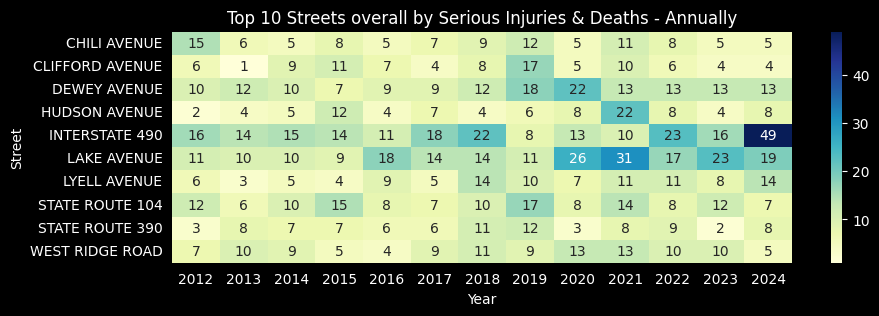

In [7]:
cper_m_per_y = pd.crosstab(
    annualframe["OnStreet_standardized"],
    annualframe["CrashDate"].dt.year,
)
annualframe_pivot = pd.pivot_table(annualframe, index="OnStreet_standardized",columns="CaseYear",values="Serious_and_Fatal_Injuries", aggfunc="sum")
print(annualframe_pivot)
plt.figure(figsize=(10, 3))
sns.heatmap(annualframe_pivot, annot=True, cmap="YlGnBu")
plt.title("Top 10 Streets overall by Serious Injuries & Deaths - Annually")
plt.yticks(rotation=0)  # horizontal
plt.xlabel("Year")
plt.ylabel("Street")

# Save figure as PDF
#pdf_file = "Crashes_per_Month_per_Year.pdf"
#plt.savefig(pdf_file, bbox_inches='tight')  # tight layout to fit table nicely
plt.show()

CrashMonth             1   2   3   4   5   6   7   8   9   10  11  12
OnStreet_standardized                                                
CHILI AVENUE            6   7   5   6  13   9  12  10   5   6  13   9
CLIFFORD AVENUE         1   6   4   5   5  20  14   9   8  11   6   3
DEWEY AVENUE            5   4  12  16  16  11  16  14  18  13  22  14
HUDSON AVENUE          12   3   9   4   9   4  14   8  11   7   6   7
INTERSTATE 490         19  23   9  13  19  24  21  17  14  19  35  16
LAKE AVENUE            18  17  21  13  17  17  20  20  15  20  16  19
LYELL AVENUE           11  10   9   7   5  10   9   6  10  13  13   4
STATE ROUTE 104         9  13   9  14  15  14   8  16  10  15   5   6
STATE ROUTE 390         4   9   5   7   9   6   9   8   5  16   8   4
WEST RIDGE ROAD         5  11   9   8   5   8  13  15  17   9   9   6


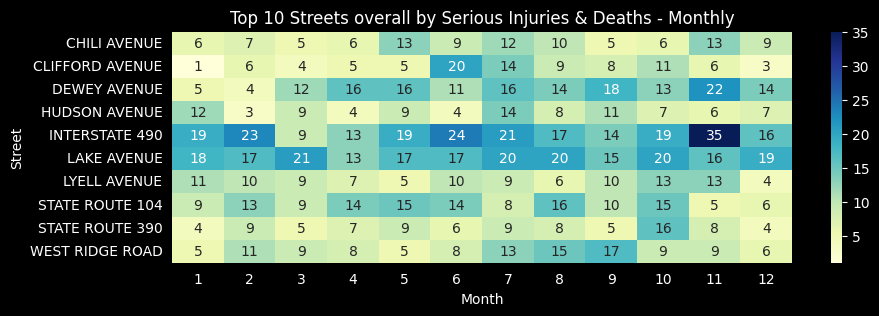

In [8]:
annualframe['CrashMonth'] = annualframe['CrashDate'].dt.month
annualframe_pivot = pd.pivot_table(annualframe, index="OnStreet_standardized",columns="CrashMonth",values="Serious_and_Fatal_Injuries", aggfunc="sum")
print(annualframe_pivot)
plt.figure(figsize=(10, 3))
sns.heatmap(annualframe_pivot, annot=True, cmap="YlGnBu")
plt.title("Top 10 Streets overall by Serious Injuries & Deaths - Monthly")
plt.yticks(rotation=0)  # horizontal
plt.xlabel("Month")
plt.ylabel("Street")

# Save figure as PDF
#pdf_file = "Crashes_per_Month_per_Year.pdf"
#plt.savefig(pdf_file, bbox_inches='tight')  # tight layout to fit table nicely
plt.show()

In [9]:
streets = dropped_df["OnStreet_standardized"].unique()
years = dropped_df["CaseYear"].unique()
dropped_df['CaseMonth'] = dropped_df['CrashDate'].dt.month
months = annualframe['CrashMonth'] .unique()
totalseriousinj_yearly = []
years.sort()
months.sort()


In [10]:
#for year in years:
#    print(year)
#    year_df = dropped_df.loc[dropped_df['CaseYear'] == year]
#
#    for street in streets:
#        totalseriousinj_yearly.append([year, street, year_df[(dropped_df['OnStreet_standardized']==street)].Serious_and_Fatal_Injuries.sum()])
#totalseriousinj_yearly

#Code to generate sums of streets by year. Don't run unless you have to. It takes 20 minutes.

In [11]:
#cols = ['CaseYear', 'OnStreet', 'Serious_and_Fatal_Injuries']
#injframe_yearly = pd.DataFrame(totalseriousinj_yearly, columns=cols)
#injframe_yearly.to_csv('yearlyseriousdeaths.csv', index=False)
#months



In [12]:
#totalseriousinj_monthly=[]
#for month in months:
#    print(month)
#    month_df = dropped_df.loc[dropped_df['CaseMonth'] == month]
#
#    for street in streets:
#        totalseriousinj_monthly.append([month, street, month_df[(dropped_df['OnStreet_standardized']==street)].Serious_and_Fatal_Injuries.sum()])
#totalseriousinj_monthly
#again this takes 20 minutes to run lmao

In [13]:
#print(totalseriousinj_monthly)
#cols = ['CaseMonth', 'OnStreet', 'Serious_and_Fatal_Injuries']
#totalseriousinj_monthly = pd.DataFrame(totalseriousinj_monthly, columns=cols)
#totalseriousinj_monthly.to_csv('monthlyseriousdeaths.csv', index=False)

In [14]:

injframe_yearly = pd.read_csv("yearlyseriousdeaths.csv")

injframe_monthly = pd.read_csv("monthlyseriousdeaths.csv")

In [26]:
#Here we're working out the top 7 crashes every year (can be more but making it 7 makes it easier on the heatmap
#yeartop15 = pd.DataFrame()
top5streets = []

for year in years:
    top = injframe_yearly[injframe_yearly['CaseYear'] == year]
    top=top.sort_values('Serious_and_Fatal_Injuries', ascending=False)
    top = top.head(7)
    #print(top5streets)
    for t in top["OnStreet"].values:
        top5streets.append(t)

    #yeartop15 = pd.concat([yeartop15,top],axis=0,ignore_index=True)

    #name = 'annualcrashlists/'
    #name += str(year)
    #name += '_top15streetsseriousdeaths.csv'
    #top.to_csv(name, index=False)
#yeartop15
top5streets = list(dict.fromkeys(top5streets))
print(top5streets)
yeartop5 = injframe_yearly[injframe_yearly["OnStreet"].isin(top5streets)]


['INTERSTATE 490', 'CHILI AVENUE', 'STATE ROUTE 104', 'LAKE AVENUE', 'SPENCERPORT ROAD', 'BUFFALO ROAD', 'DEWEY AVENUE', 'STATE ROUTE 490', 'WEST RIDGE ROAD', 'INTERSTATE 390', 'EAST HENRIETTA ROAD', 'CLIFFORD AVENUE', 'HUDSON AVENUE', 'STATE ROUTE 31', 'LAKE ROAD', 'LYELL AVENUE', 'EAST MAIN STREET', 'STATE ROUTE 590', 'STATE ROUTE 390', 'WEST HENRIETTA ROAD', 'NORTH CLINTON AVENUE', 'UNION STREET', 'NORTON STREET', 'EAST RIDGE ROAD']


In [27]:

yeartop15_pivot = pd.pivot_table(yeartop5.fillna(0), index="OnStreet", columns="CaseYear",
                                 values="Serious_and_Fatal_Injuries", aggfunc="sum",fill_value=0)

yeartop15_pivot.fillna(0)
yeartop15_pivot


CaseYear,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
OnStreet,,,,,,,,,,,,,
BUFFALO ROAD,10,6,9,2,6,5,7,5,2,3,5,4,7
CHILI AVENUE,15,6,5,8,5,7,9,12,5,11,8,5,5
CLIFFORD AVENUE,6,1,9,11,7,4,8,17,5,10,6,4,4
DEWEY AVENUE,10,12,10,7,9,9,12,18,22,13,13,13,13
EAST HENRIETTA ROAD,6,8,2,6,12,5,4,2,0,2,5,9,2
EAST MAIN STREET,8,5,4,0,8,8,2,5,0,6,6,4,6
EAST RIDGE ROAD,1,1,1,0,3,2,3,2,1,7,3,3,11
HUDSON AVENUE,2,4,5,12,4,7,4,6,8,22,8,4,8
INTERSTATE 390,5,10,5,7,2,7,3,6,8,7,5,8,11


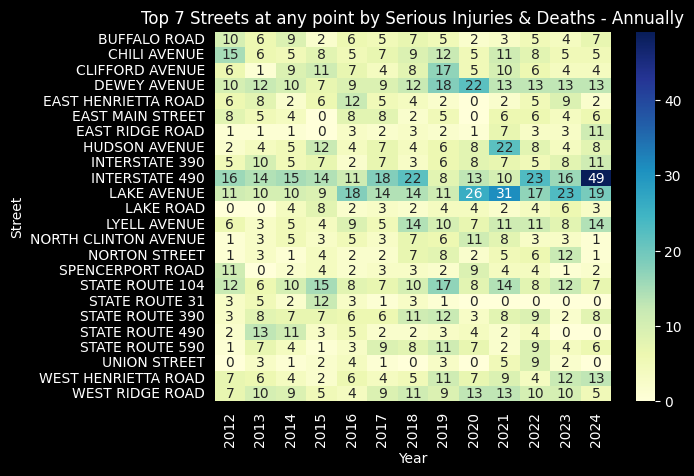

In [28]:
sns.heatmap(yeartop15_pivot, annot=True, cmap="YlGnBu")
plt.title("Top 7 Streets at any point by Serious Injuries & Deaths - Annually")
plt.yticks(rotation=0)  # horizontal
plt.xlabel("Year")
plt.ylabel("Street")

plt.show()


['INTERSTATE 490', 'LAKE AVENUE', 'HUDSON AVENUE', 'LYELL AVENUE', 'PITTSFORD PALMYRA ROAD', 'STATE ROUTE 104', 'LONG POND ROAD', 'WEST RIDGE ROAD', 'STATE ROUTE 390', 'BAY STREET', 'NORTH STREET', 'DEWEY AVENUE', 'WEST HENRIETTA ROAD', 'NORTH CLINTON AVENUE', 'STREET PAUL STREET', 'CHILI AVENUE', 'BUFFALO ROAD', 'CLIFFORD AVENUE', 'PENFIELD ROAD', 'STATE ROUTE 590', 'NORTON STREET', 'LATTA ROAD', 'EAST HENRIETTA ROAD', 'EMPIRE BOULEVARD']


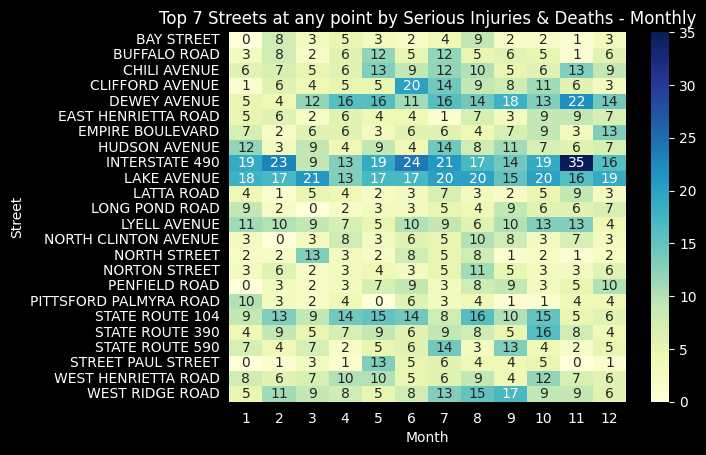

In [29]:
# Top 5 crashes per month
yeartop15 = pd.DataFrame()
top5streets = []

for month in months:
    top = injframe_monthly[injframe_monthly['CaseMonth'] == month]
    top=top.sort_values('Serious_and_Fatal_Injuries', ascending=False)
    top = top.head(7)
    #print(top5streets)
    for t in top["OnStreet"].values:
        top5streets.append(t)

    #yeartop15 = pd.concat([yeartop15,top],axis=0,ignore_index=True)

    #name = 'annualcrashlists/'
    #name += str(year)
    #name += '_top15streetsseriousdeaths.csv'
    #top.to_csv(name, index=False)
#yeartop15
top5streets = list(dict.fromkeys(top5streets))
print(top5streets)
yeartop5 = injframe_monthly[injframe_monthly["OnStreet"].isin(top5streets)]

yeartop15_pivot = pd.pivot_table(yeartop5.fillna(0), index="OnStreet", columns="CaseMonth",
                                 values="Serious_and_Fatal_Injuries", aggfunc="sum",fill_value=0)

yeartop15_pivot.fillna(0)
yeartop15_pivot

sns.heatmap(yeartop15_pivot, annot=True, cmap="YlGnBu")
plt.title("Top 7 Streets at any point by Serious Injuries & Deaths - Monthly")
plt.yticks(rotation=0)
plt.xlabel("Month")
plt.yticks(rotation=0)  # horizontal
plt.xlabel("Month")
plt.ylabel("Street")

plt.show()


['WEST HENRIETTA ROAD', 'STATE ROUTE 590', 'EAST MAIN STREET', 'EMPIRE BOULEVARD', 'SPENCERPORT ROAD', 'STATE ROUTE 490', 'INTERSTATE 390', 'BUFFALO ROAD', 'CHILI AVENUE', 'NORTON STREET', 'EAST HENRIETTA ROAD', 'CLIFFORD AVENUE', 'STATE ROUTE 104', 'DRIVING PARK AVENUE', 'WEST MAIN STREET', 'MANITOU ROAD', 'STATE ROUTE 390', 'INTERSTATE 90', 'LYELL AVENUE', 'ROOSEVELT HIGHWAY', 'PORTLAND AVENUE', 'GENESEE STREET', 'HUDSON AVENUE', 'MONROE AVENUE', 'PENFIELD ROAD', 'NORTH STREET', 'WEST RIDGE ROAD', 'GOODMAN STREET NORTH', 'HOWARD ROAD', 'NORTH CLINTON AVENUE', 'BAY STREET', 'SCOTTSVILLE ROAD', 'LONG POND ROAD', 'CULVER ROAD', 'JOSEPH AVENUE', 'JEFFERSON ROAD', 'MOUNT READ BOULEVARD', 'CLOVER STREET']


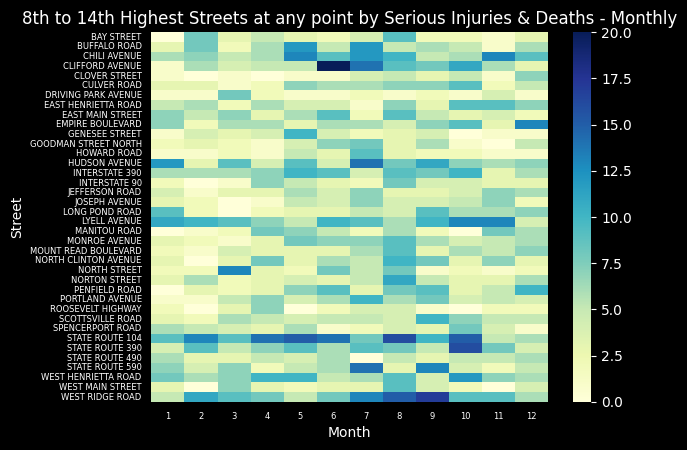

In [46]:
# 5th to 10th most common crashes per month

yeartop15 = pd.DataFrame()
yeartop5 = []
top5streets = []

for month in months:
    top = injframe_monthly[injframe_monthly['CaseMonth'] == month]
    top=top.sort_values('Serious_and_Fatal_Injuries', ascending=False)
    top = top.head(14)
    top = top.tail(7)
    #print(top5streets)
    for t in top["OnStreet"].values:
        top5streets.append(t)

    #yeartop15 = pd.concat([yeartop15,top],axis=0,ignore_index=True)

    #name = 'annualcrashlists/'
    #name += str(year)
    #name += '_top15streetsseriousdeaths.csv'
    #top.to_csv(name, index=False)
#yeartop15
top5streets = list(dict.fromkeys(top5streets))
print(top5streets)
yeartop5 = injframe_monthly[injframe_monthly["OnStreet"].isin(top5streets)]

yeartop15_pivot = pd.pivot_table(yeartop5.fillna(0), index="OnStreet", columns="CaseMonth",
                                 values="Serious_and_Fatal_Injuries", aggfunc="sum",fill_value=0)

yeartop15_pivot.fillna(0)
yeartop15_pivot
sns.color_palette(palette='YlGnBu')
map = sns.heatmap(yeartop15_pivot, annot=False, cmap="YlGnBu", yticklabels=1)
map.tick_params(axis='both', labelsize=6)

plt.title("8th to 14th Highest Streets at any point by Serious Injuries & Deaths - Monthly")
plt.yticks(rotation=0)
plt.xlabel("Month")
plt.yticks(rotation=0)  # horizontal
plt.xlabel("Month")
plt.ylabel("Street")

plt.show()


['PENFIELD ROAD', 'INTERSTATE 590', 'MONROE AVENUE', 'EAST MAIN STREET', 'WEST RIDGE ROAD', 'WEST MAIN STREET', 'WEST HENRIETTA ROAD', 'STATE ROUTE 390', 'STATE ROUTE 590', 'SCOTTSVILLE ROAD', 'BUFFALO ROAD', 'STATE ROUTE 104', 'CHILI AVENUE', 'SCOTTSVILLE MUMFORD ROAD', 'MOUNT READ BOULEVARD', 'LATTA ROAD', 'EMPIRE BOULEVARD', 'CULVER ROAD', 'INTERSTATE 390', 'JEFFERSON ROAD', 'DEWEY AVENUE', 'STATE STREET', 'CLIFFORD AVENUE', 'RIDGE ROAD WEST', 'HUDSON AVENUE', 'GOODMAN STREET NORTH', 'RIDGEWAY AVENUE', 'CARTER STREET', 'INTERSTATE 90', 'LAKE AVENUE', 'PITTSFORD PALMYRA ROAD', 'LYELL AVENUE', 'NORTON STREET', 'INTERSTATE 490', 'NORTH CLINTON AVENUE', 'STREET PAUL STREET', 'LONG POND ROAD', 'EAST HENRIETTA ROAD', 'PORTLAND AVENUE', 'NORTH STREET', 'UPPER FALLS BOULEVARD']


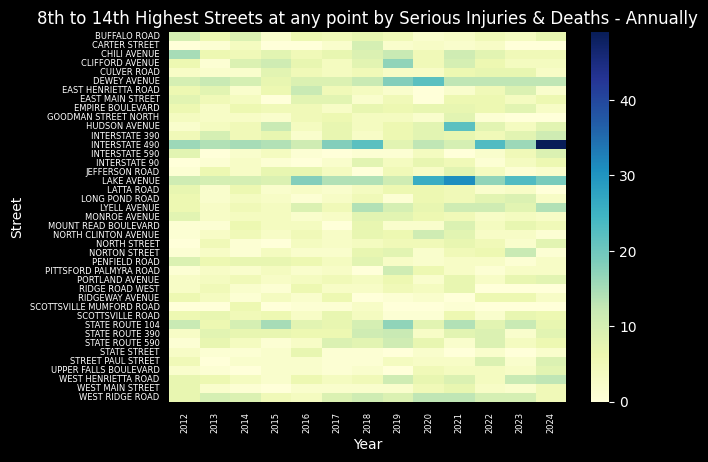

In [47]:
#Here we're working out the top 7 crashes every year (can be more but making it 7 makes it easier on the heatmap
#yeartop15 = pd.DataFrame()
top5streets = []

for year in years:
    top = injframe_yearly[injframe_yearly['CaseYear'] == year]
    top=top.sort_values('Serious_and_Fatal_Injuries', ascending=False)
    top = top.head(14)
    top = top.tail(7)
    #print(top5streets)
    for t in top["OnStreet"].values:
        top5streets.append(t)

    #yeartop15 = pd.concat([yeartop15,top],axis=0,ignore_index=True)

    #name = 'annualcrashlists/'
    #name += str(year)
    #name += '_top15streetsseriousdeaths.csv'
    #top.to_csv(name, index=False)
#yeartop15
top5streets = list(dict.fromkeys(top5streets))
print(top5streets)
yeartop5 = injframe_yearly[injframe_yearly["OnStreet"].isin(top5streets)]


yeartop15_pivot = pd.pivot_table(yeartop5.fillna(0), index="OnStreet", columns="CaseYear",
                                 values="Serious_and_Fatal_Injuries", aggfunc="sum",fill_value=0)

yeartop15_pivot.fillna(0)
yeartop15_pivot

map = sns.heatmap(yeartop15_pivot, annot=False, cmap="YlGnBu", yticklabels=1)
map.tick_params(axis='both', labelsize=6)

plt.title("8th to 14th Highest Streets at any point by Serious Injuries & Deaths - Annually")
plt.yticks(rotation=0)  # horizontal
plt.xlabel("Year")
plt.ylabel("Street")

plt.show()
